In [1]:
from mesh import three_cubes

size = 0.05
filename = f"meshes/mesh_{size}.msh"

three_cubes(filename, size=size)

Info    : Meshing 1D...nts                                                                                                             
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 60%] Meshing curve 17 (Line)
Info    : [ 70%] Meshing curve 18 (Line)
Info    : [ 70%] Meshing curve 19 (Line)
Info    : [ 70%] Meshing curve 20 (Line)
Info    : [ 80%] Meshing curve 21 (Line)
Info    : [ 

In [2]:
from convert_mesh import convert_mesh


volume_file = f"meshes/mesh_{size}.xdmf"
facet_file = f"meshes/mesh_{size}_facet.xdmf"

print(filename, volume_file, facet_file)

nb_cells, nb_facets = convert_mesh(filename, volume_file, facet_file)

meshes/mesh_0.05.msh meshes/mesh_0.05.xdmf meshes/mesh_0.05_facet.xdmf

Surface IDs:  [4 5 6 7]
Volume IDs:  [1 2 3]


In [3]:
def run(volume_file: str, facet_file: str) -> float:
    from script_festim_1 import run_festim_1
    import time

    start = time.perf_counter()
    run_festim_1(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time

In [4]:
import ipyparallel as ipp
import numpy as np
import os

if "CI" in os.environ:
    num_procs = [1, 2]
else:
    num_procs = [1, 2, 4, 8, 16]

runtimes = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")

    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    print(elapsed_times)

    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    # get the maximum runtime
    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes[i] = runtime

# save data to csv
import pandas as pd
df = pd.DataFrame(data={"num_procs": num_procs, "runtimes": runtimes})
df.to_csv("runtimes_festim_1.csv", index=False)

Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.59s/engine]
[85.2236237199977]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1619080, 'identifier': 'ipcontroller-1731446454-04du-1619018'}
Stopping engine(s): 1731446455
Output for ipengine-1731446454-04du-1731446455-1619018:
2024-11-12 16:20:55.896 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 16:20:55.896 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 16:20:55.931 [IPEngine] Registering with controller at tcp://127.0.0.1:44233
2024-11-12 16:20:55.933 [IPEngine] Shell_addrs: ['tcp://127.0.0.1:35137', 'tcp://127.0.0.1:56643', 'tcp://127.0.0.1:45539']
2024-11-12 16:20:55.933 [IPEngine] Connecting shell to tcp://127.0.0.1:35137
2024-11-12 16:20:55.934 [IPEngine] Connecting shell to tcp://127.0.0.1:56643
2024-11-12 16:20:55.934 [IPEngine] Connecting shell to tcp://127.0.0.1:45539
2024-11

/tmp/ipykernel_1619018/3282433569.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.78s/engine]
[386.76094319997355, 386.78556841801037]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1619896, 'identifier': 'ipcontroller-1731446550-bb1k-1619018'}
Stopping engine(s): 1731446551
Output for ipengine-1731446550-bb1k-1731446551-1619018:
2024-11-12 16:22:31.683 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 16:22:31.683 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 16:22:31.683 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 16:22:31.683 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 16:22:31.699 [IPEngine.0] Registering with controller at tcp://127.0.0.1:43329
2024-11-12 16:22:31.699 [IPEngine.1] Registering with controller at tcp://127.0.0.1:43329
2024-11-12 16:22:31.699 [IPEngine.0] Requesting id: 0
2024-11-12 16:22:31.700 [IPEngine.1] Requesting id: 1
2024-11

/tmp/ipykernel_1619018/3282433569.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.37s/engine]
[342.77513985399855, 342.7838300560252, 342.7939264079905, 342.78201442499994]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1622359, 'identifier': 'ipcontroller-1731446947-0w71-1619018'}
Stopping engine(s): 1731446948
Output for ipengine-1731446947-0w71-1731446948-1619018:
2024-11-12 16:29:08.617 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 16:29:08.630 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 16:29:08.631 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 16:29:08.627 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 16:29:08.627 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 16:29:08.643 [IPEngine.1] Registering with controller at tcp://127.0.0.1:47473
2024-11-12 16:29:08.643 [IPEngine.2] Registering with controller at tcp://127.0.0.1:47473
2024

/tmp/ipykernel_1619018/3282433569.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 8/8 [00:05<00:00,  1.43engine/s]
[692.152171469992, 692.1502433299902, 692.1588143469999, 692.1956607449974, 692.1832337889937, 692.1699160510034, 692.1416943760123, 692.1739941650012]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1625573, 'identifier': 'ipcontroller-1731447300-h7j7-1619018'}
Stopping engine(s): 1731447301
Output for ipengine-1731447300-h7j7-1731447301-1619018:
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-12 16:35:02.099 [IPEngine.0] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-12 16:35:02.099 [IPEngine.1] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-12 16:35:02.112 [IPEngine.2] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-12 16:35:02.115 [IPEngine.2] WARNING | debu

/tmp/ipykernel_1619018/3282433569.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 16 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 16/16 [00:05<00:00,  2.86engine/s]
[782.8972714059928, 782.9990309170098, 782.9644769610022, 783.0017290520191, 782.9780405469937, 782.945950703026, 782.9003970309859, 782.9880347599974, 782.9299866299843, 782.9217725530034, 782.9339497329784, 782.9411801170208, 782.9285186929919, 782.9396380200051, 783.0005129670026, 782.9437173479819]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1631568, 'identifier': 'ipcontroller-1731448003-sbf6-1619018'}
Stopping engine(s): 1731448004
Output for ipengine-1731448003-sbf6-1731448004-1619018:
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-12 16:46:45.204 [IPEngine.11] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-12 16:46:45.205 [IPEngine.11] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-12 16:46:45.205 [IPEngine.11] Completed registration with id 11
2024-11-12 16:46:45.213 

/tmp/ipykernel_1619018/3282433569.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


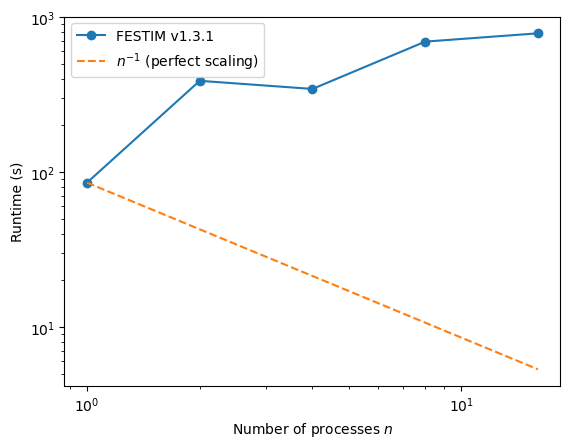

In [5]:
import matplotlib.pyplot as plt
from festim import __version__

plt.plot(num_procs, runtimes, marker="o", label=f"FESTIM v{__version__}")

n = np.linspace(1, 16, 100)
plt.plot(n, runtimes[0] * n**-1, linestyle="--", label="$n^{-1}$ (perfect scaling)")

plt.xlabel("Number of processes $n$")
plt.ylabel("Runtime (s)")

plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()